In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np


from network import DDPM, ContextUnet, ContextUnetColored, Classifier
from dataset import add_hue_confounded

In [31]:
n_T = 400 # 500
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 1
n_classes = 10
n_feat = 256 # 128 ok, 256 better (but slower)
save_model = False
cond_mode = "AdaGN"
# save_dir = './data/diffusion_outputs10/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

ddpm = DDPM(nn_model=ContextUnetColored(in_channels=3, n_feat=n_feat, n_classes=n_classes, cond_mode=cond_mode), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1, color=True)
ddpm.to(device)

ddpm.load_state_dict(torch.load("./experiments/240514_1/model/model_20.pth", map_location=device))
# ddpm.load_state_dict(torch.load("./diff_to_download/240504_1_model_29.pth", map_location=device))

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

testset = MNIST("./data", train=False, download=True, transform=tf)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=5)
ddpm.eval()


DDPM(
  (nn_model): ContextUnetColored(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(256, 256, kernel_si

In [3]:
results = ddpm.sample(10, (3,28,28),device,2)
results = results[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


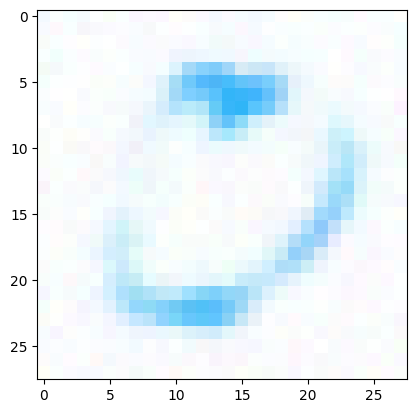

In [4]:
plt.imshow((-1 * results[0].detach().cpu() + 1).permute(1,2,0))

In [7]:
x, y, hues = torch.load("./classifiedMNIST/real_data/batch_0.pth", map_location=device)
y_hats, logits = torch.load("./classifiedMNIST/predicted_label/batch_0.pth", map_location=device)

In [9]:
# get one sample that is classified wrong and one correct
p_unif = 0
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load(f"./trained_classifiers/model{p_unif}_10.pt", map_location=device))

<All keys matched successfully>

In [30]:
x_sample_wrong = x[0]
y_true_sample_wrong = y[0].view(-1,)
y_sample_wrong = y_hats[f'{p_unif}'][0]
x_sample_correct = x[1]
y_true_sample_correct = y[1].view(-1,)
y_sample_correct = y_hats[f'{p_unif}'][1]

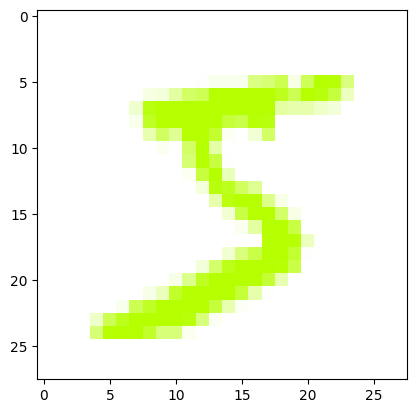

In [46]:
plt.imshow((-1*x_sample_wrong.permute(1,2,0)+1).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


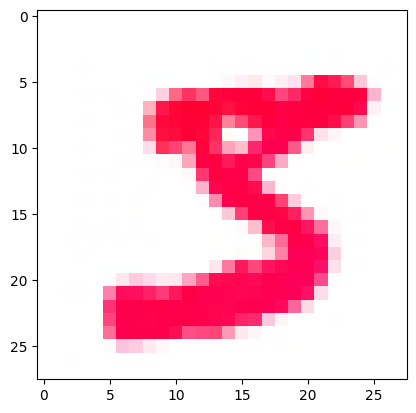

In [86]:
# hue uncond cf from 8 to 5 (y_true is 5)
true_hues = hues[0]
# true_hues = torch.tensor([true_hues]).to(device)
u = ddpm.abduct(x_sample_wrong.view(1,3,28,28), \
                y_sample_wrong,\
                size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=1)
x_cf_wrong_uncond = ddpm.reconstruct(u, y_true_sample_wrong.view(-1,), size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=1)
plt.imshow((-1*x_cf_wrong_uncond[0]+1).permute(1,2,0).detach().cpu())

In [5]:
# hue cond cf from 5 to 8 (y_true is 8)
true_hues = hues[0]
# true_hues = torch.tensor([true_hues]).to(device)
u = ddpm.abduct(x_sample_wrong.view(1,3,28,28), \
                y_sample_wrong,\
                size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=0)
x_cf_wrong_cond = ddpm.reconstruct(u, y_true_sample_wrong.view(-1,), size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=0)
plt.imshow((-1*x_cf_wrong_cond[0]+1).permute(1,2,0).detach().cpu())

NameError: name 'hues' is not defined

In [68]:
y_cf_uncond = classifier(x_cf_wrong_uncond)
print(torch.exp(y_cf_uncond))
print(torch.argmax(y_cf_uncond,dim=1))
print(torch.exp(logits[f'{p_unif}'][0]))

tensor([[0.0115, 0.0120, 0.0086, 0.5079, 0.0047, 0.3734, 0.0170, 0.0182, 0.0367,
         0.0100]], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([3], device='cuda:0')
tensor([0.0364, 0.0071, 0.0071, 0.0940, 0.0105, 0.1984, 0.0375, 0.0785, 0.3190,
        0.2115], device='cuda:0', grad_fn=<ExpBackward0>)


In [71]:
y_cf_cond = classifier(x_cf_wrong_cond)
print(torch.exp(y_cf_cond))
print(torch.argmax(y_cf_cond,dim=1))


tensor([[0.0322, 0.0111, 0.0103, 0.1533, 0.0185, 0.3477, 0.0336, 0.0988, 0.1493,
         0.1453]], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([5], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


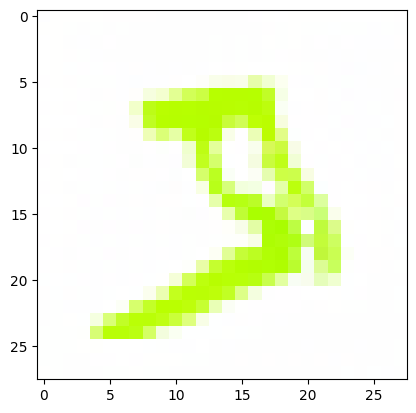

In [84]:
# now from 8 to 0 (groundtruth 5)
x_cf_wrong_cond_to0 = ddpm.reconstruct(u, torch.tensor([2],device=device).view(-1,), size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=0)
plt.imshow((-1*x_cf_wrong_cond_to0[0]+1).permute(1,2,0).detach().cpu())

In [85]:
y_cf_cond_to0 = classifier(x_cf_wrong_cond_to0)
print(torch.exp(y_cf_cond_to0))
print(torch.argmax(y_cf_cond_to0,dim=1))

tensor([[0.0513, 0.0195, 0.0223, 0.1215, 0.0289, 0.1063, 0.0448, 0.2607, 0.2056,
         0.1391]], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([7], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


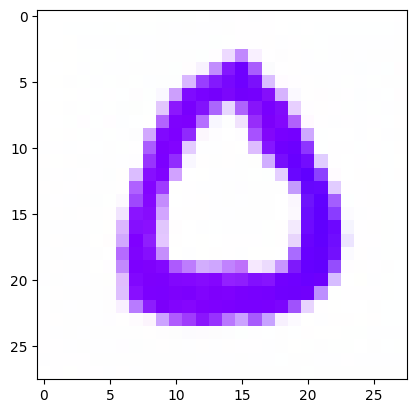

In [91]:
# now from 8 to 0 (groundtruth 5); uncond
x_cf_wrong_uncond_to0 = ddpm.reconstruct(u, torch.tensor([0],device=device).view(-1,), size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=1)
plt.imshow((-1*x_cf_wrong_uncond_to0[0]+1).permute(1,2,0).detach().cpu())

In [92]:
y_cf_uncond_to0 = classifier(x_cf_wrong_uncond_to0)
print(torch.exp(y_cf_uncond_to0))
print(torch.argmax(y_cf_uncond_to0,dim=1))

tensor([[0.4824, 0.0069, 0.4301, 0.0076, 0.0029, 0.0018, 0.0032, 0.0060, 0.0038,
         0.0554]], device='cuda:0', grad_fn=<ExpBackward0>)
tensor([0], device='cuda:0')


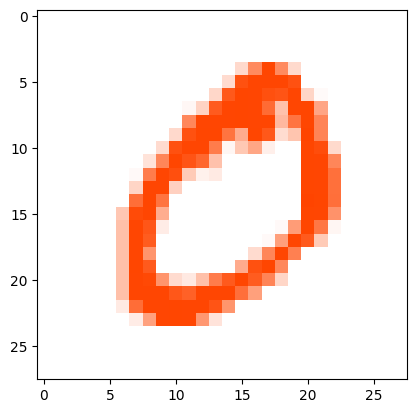

In [24]:
plt.imshow((-1*x_sample_correct+1).permute(1,2,0).detach().cpu())

In [18]:
y==y_hats['0']

tensor([False,  True,  True,  True, False,  True,  True, False, False, False,
        False, False,  True, False,  True,  True, False,  True,  True, False,
         True,  True,  True,  True, False,  True, False,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False,  True, False, False,  True, False,  True, False,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True, False,  True,  True, False, False, False, False,
        False,  True, False, False, False,  True,  True, False, False, False,
        False,  True, False,  True,  True,  True, False,  True,  True, False,
         True, False,  True,  True, False,  True, False, False,  True, False,
        False, False,  True, False, False,  True, False, False, False, False,
         True, False,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True, False, 

In [20]:
for x, y in testloader:
    x_test = x
    y_test = y
    break

In [21]:
x_test_colored, hue_test = add_hue_confounded(x_test, y_test, sigma=0.05)
x_test_colored = x_test_colored.reshape(3,28,28).to(device)
hue_test = hue_test.to(device)

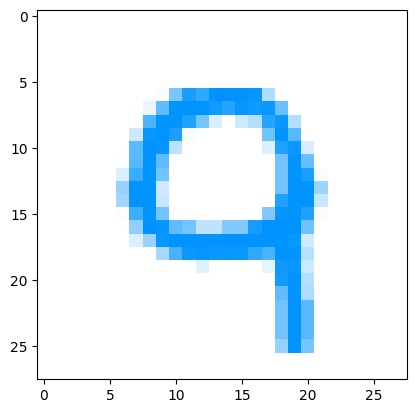

In [22]:
plt.imshow((1-x_test_colored).permute(1,2,0).detach().cpu().numpy())

In [14]:
true_hues = 0.0
true_hues = torch.tensor([true_hues+0.05]).to(device)
u = ddpm.abduct(results[0], \
                torch.tensor([0]).to(device),\
                size=(3,28,28), device=device, guide_w=2, hues=true_hues, hue_uncond=0)

In [32]:
u_test = ddpm.abduct(x_test_colored, \
                y_test.to(device),\
                size=(3,28,28), device=device, guide_w=2, hues=hue_test)

In [24]:
hue_test

tensor([0.0702], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


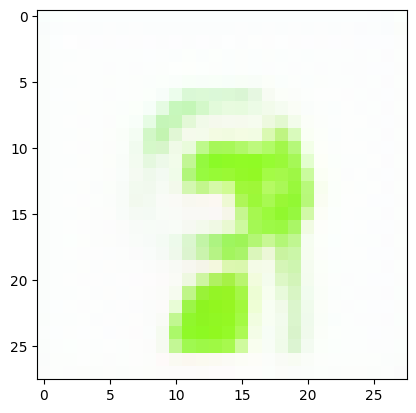

In [35]:
x_cf_test = ddpm.reconstruct(u_test, \
                        torch.tensor([9], dtype=torch.int64, device=device),\
                        size=(3,28,28), guide_w=2, \
                        hues=torch.tensor([0.7702],device=device), hue_uncond=0)
plt.imshow((-1*x_cf_test[0]+1).permute(1,2,0).detach().cpu().numpy())

In [12]:
u_random = torch.randn_like(u_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


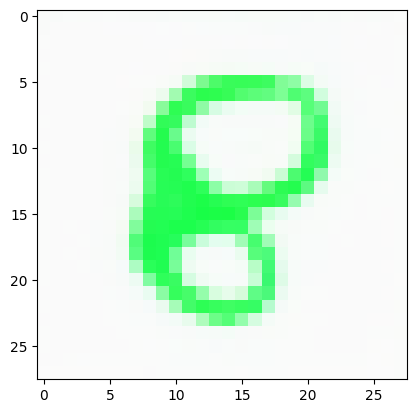

In [15]:
x_cf = ddpm.reconstruct(u_random, \
                        torch.tensor([1], dtype=torch.int64, device=device),\
                        size=(3,28,28), device=device, guide_w=2, \
                        hues=torch.tensor([0.85],device=device), hue_uncond=0, c_uncond=1)
plt.imshow((-1*x_cf[0]+1).permute(1,2,0).detach().cpu().numpy())

In [58]:
from network import Classifier
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('trained_classifiers/model0.05_10.pt', map_location=device))
classifier.eval()

Classifier(
  (conv11): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv13): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (conv14): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1))
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv22): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv23): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv24): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1))
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv32): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv33): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv34): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc11): Linear(in_features=7744, out_features=256, bias=True)
  (fc12

In [63]:
logit_cf = classifier(x_cf)
y_cf = torch.argmax(logit_cf, dim=1)
print(logit_cf)
print(y_cf)

tensor([[-4.2543, -3.9515, -3.6870, -3.7627, -4.7838, -4.4832, -4.1890, -4.0020,
         -0.1733, -3.7157]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([8], device='cuda:0')


In [17]:
tmpdata=torch.load('./classifiedMNIST/model0.01_10/batch_0.pth')

In [20]:
for i in tmpdata:
    print(i.shape)

torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128])
torch.Size([128, 10])
torch.Size([128])


In [ ]:
n_T = 400 # 500
device = "cuda:7" if torch.cuda.is_available() else "cpu"
batch_size = 1
n_classes = 10
n_feat = 256 # 128 ok, 256 better (but slower)
save_model = False
# save_dir = './data/diffusion_outputs10/'
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

ddpm_base = DDPM(nn_model=ContextUnet(in_channels=3, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm_base.to(device)

# optionally load a model
ddpm_base.load_state_dict(torch.load("./experiments/240503_3/model/model_10.pth", map_location=device))

ddpm_base.eval()

In [ ]:
results = ddpm.sample(10, (3,28,28),device,1)
results = results[0]
plt.imshow((-1 * results[1].detach().cpu() + 1).permute(1,2,0))

In [ ]:

u_base = ddpm_base.abduct(results[1], torch.tensor([1], dtype=torch.int64).to(device), size=(3,28,28), device=device, guide_w=1)

In [ ]:
x_cf_base = ddpm_base.reconstruct(u, \
                        torch.tensor([5], dtype=torch.int64, device=device),\
                        size=(3,28,28), device=device, guide_w=1)
plt.imshow((-1*x_cf_base[0]+1).permute(1,2,0).detach().cpu().numpy())

In [ ]:
# use plt.imshow to show one sample
image = results[0][0].clone().cpu().detach().numpy()
image.shape

In [ ]:
# image.shape is (1,28,28) grey scale. How to imshow it?
plt.imshow(image[0], cmap='gray')